In [ ]:
#!pip install chainer
#!pip install chainercv

In [ ]:
# 
# https://github.com/chainer/chainer/blob/master/examples/dcgan/net.py
# 
import numpy as np

import chainer
import chainer.functions as F
import chainer.links as L

def add_noise(device, h, sigma=0.2):
    if chainer.config.train:
        #xp = device.xp
        xp = device
        randn = xp.random.randn(*h.shape)
        return h + sigma * randn
    else:
        return h

class Generator(chainer.Chain):

    def __init__(self, n_hidden, bottom_width=4, ch=512, wscale=0.02):
        super(Generator, self).__init__()
        self.n_hidden = n_hidden
        self.ch = ch
        self.bottom_width = bottom_width

        with self.init_scope():
            w = chainer.initializers.Normal(wscale)
            self.l0 = L.Linear(self.n_hidden, bottom_width * bottom_width * ch, initialW=w)
            self.dc1 = L.Deconvolution2D(ch, ch // 2, 4, 2, 1, initialW=w)
            self.dc2 = L.Deconvolution2D(ch // 2, ch // 4, 4, 2, 1, initialW=w)
            self.dc3 = L.Deconvolution2D(ch // 4, ch // 8, 4, 2, 1, initialW=w)
            self.dc4 = L.Deconvolution2D(ch // 8, 3, 3, 1, 1, initialW=w)
            self.bn0 = L.BatchNormalization(bottom_width * bottom_width * ch)
            self.bn1 = L.BatchNormalization(ch // 2)
            self.bn2 = L.BatchNormalization(ch // 4)
            self.bn3 = L.BatchNormalization(ch // 8)

    def make_hidden(self, batchsize):
        dtype = chainer.get_dtype()
        return np.random.uniform(-1, 1, (batchsize, self.n_hidden, 1, 1)).astype(dtype)

    def forward(self, z):
        h = F.reshape(F.relu(self.bn0(self.l0(z))), (len(z), self.ch, self.bottom_width, self.bottom_width))
        h = F.relu(self.bn1(self.dc1(h)))
        h = F.relu(self.bn2(self.dc2(h)))
        h = F.relu(self.bn3(self.dc3(h)))
        x = F.sigmoid(self.dc4(h))
        return x

class Discriminator(chainer.Chain):

    def __init__(self, bottom_width=4, ch=512, wscale=0.02, device='xyz'):
        w = chainer.initializers.Normal(wscale)
        super(Discriminator, self).__init__()
        self.device = device
        with self.init_scope():
            self.c0_0 = L.Convolution2D(3, ch // 8, 3, 1, 1, initialW=w)
            self.c0_1 = L.Convolution2D(ch // 8, ch // 4, 4, 2, 1, initialW=w)
            self.c1_0 = L.Convolution2D(ch // 4, ch // 4, 3, 1, 1, initialW=w)
            self.c1_1 = L.Convolution2D(ch // 4, ch // 2, 4, 2, 1, initialW=w)
            self.c2_0 = L.Convolution2D(ch // 2, ch // 2, 3, 1, 1, initialW=w)
            self.c2_1 = L.Convolution2D(ch // 2, ch // 1, 4, 2, 1, initialW=w)
            self.c3_0 = L.Convolution2D(ch // 1, ch // 1, 3, 1, 1, initialW=w)
            self.l4 = L.Linear(bottom_width * bottom_width * ch, 1, initialW=w)
            self.bn0_1 = L.BatchNormalization(ch // 4, use_gamma=False)
            self.bn1_0 = L.BatchNormalization(ch // 4, use_gamma=False)
            self.bn1_1 = L.BatchNormalization(ch // 2, use_gamma=False)
            self.bn2_0 = L.BatchNormalization(ch // 2, use_gamma=False)
            self.bn2_1 = L.BatchNormalization(ch // 1, use_gamma=False)
            self.bn3_0 = L.BatchNormalization(ch // 1, use_gamma=False)

    def forward(self, x):
        device = self.device
        h = add_noise(device, x)
        h = F.leaky_relu(add_noise(device, self.c0_0(h)))
        h = F.leaky_relu(add_noise(device, self.bn0_1(self.c0_1(h))))
        h = F.leaky_relu(add_noise(device, self.bn1_0(self.c1_0(h))))
        h = F.leaky_relu(add_noise(device, self.bn1_1(self.c1_1(h))))
        h = F.leaky_relu(add_noise(device, self.bn2_0(self.c2_0(h))))
        h = F.leaky_relu(add_noise(device, self.bn2_1(self.c2_1(h))))
        h = F.leaky_relu(add_noise(device, self.bn3_0(self.c3_0(h))))
        return self.l4(h)

In [ ]:
# 
# https://github.com/chainer/chainer/blob/master/examples/dcgan/updater.py
# 
from chainer import Variable

class DCGANUpdater(chainer.training.updaters.StandardUpdater):

    def __init__(self, *args, **kwargs):
        self.gen, self.dis = kwargs.pop('models')
        super(DCGANUpdater, self).__init__(*args, **kwargs)

    def loss_dis(self, dis, y_fake, y_real):
        batchsize = len(y_fake)
        L1 = F.sum(F.softplus(-y_real)) / batchsize
        L2 = F.sum(F.softplus(y_fake)) / batchsize
        loss = L1 + L2
        chainer.report({'loss': loss}, dis)
        return loss

    def loss_gen(self, gen, y_fake):
        batchsize = len(y_fake)
        loss = F.sum(F.softplus(-y_fake)) / batchsize
        chainer.report({'loss': loss}, gen)
        return loss

    def update_core(self):
        gen_optimizer = self.get_optimizer('gen')
        dis_optimizer = self.get_optimizer('dis')

        batch = self.get_iterator('main').next()
        device = self.device
        x_real = Variable(self.converter(batch, device)) / 255.

        gen, dis = self.gen, self.dis
        batchsize = len(batch)

        y_real = dis(x_real)

        #z = Variable(device.xp.asarray(gen.make_hidden(batchsize)))
        z = Variable(chainer.cuda.cupy.asarray(gen.make_hidden(batchsize)))
        x_fake = gen(z)
        y_fake = dis(x_fake)

        dis_optimizer.update(self.loss_dis, dis, y_fake, y_real)
        gen_optimizer.update(self.loss_gen, gen, y_fake)

In [ ]:
#
# https://github.com/chainer/chainer/blob/master/examples/dcgan/visualize.py
#

import os
from PIL import Image
import chainer.backends.cuda

def out_generated_image(gen, dis, rows, cols, seed, dst):
    @chainer.training.make_extension()
    def make_image(trainer):
        np.random.seed(seed)
        n_images = rows * cols
        xp = gen.xp
        z = Variable(xp.asarray(gen.make_hidden(n_images)))
        with chainer.using_config('train', False):
            x = gen(z)
        x = chainer.backends.cuda.to_cpu(x.array)
        np.random.seed()

        x = np.asarray(np.clip(x * 255, 0.0, 255.0), dtype=np.uint8)
        _, _, H, W = x.shape
        x = x.reshape((rows, cols, 3, H, W))
        x = x.transpose(0, 3, 1, 4, 2)
        x = x.reshape((rows * H, cols * W, 3))

        preview_dir = '{}/preview'.format(dst)
        preview_path = preview_dir + '/image{:0>8}.png'.format(trainer.updater.iteration)
        if not os.path.exists(preview_dir):
            os.makedirs(preview_dir)
        Image.fromarray(x).save(preview_path)
    return make_image

In [ ]:
# Setup an optimizer
def make_optimizer(model, alpha=0.0002, beta1=0.5):
    optimizer = chainer.optimizers.Adam(alpha=alpha, beta1=beta1)
    optimizer.setup(model)
    optimizer.add_hook(chainer.optimizer_hooks.WeightDecay(0.0001), 'hook_dec')
    return optimizer

In [ ]:
import os

from chainer import training
from chainer.training import extensions

args_device = 1
args_batchsize = 50
args_n_hidden = 100
args_epoch = 1000
args_dataset = ''
args_out = 'result_class_1'
args_snapshot_interval = 1000
args_display_interval = 500
args_seed = 0

#device = chainer.cuda.get_device(args_device)
#device.use()
chainer.cuda.Device(args_device).use()
device = chainer.cuda.Device(args_device)

print(chainer.__version__)
print('Device: {}'.format(device))
print('# Minibatch-size: {}'.format(args_batchsize))
print('# n_hidden: {}'.format(args_n_hidden))
print('# epoch: {}'.format(args_epoch))
print('')

# Set up a neural network to train
gen = Generator(n_hidden=args_n_hidden)
dis = Discriminator(device=chainer.cuda.cupy)

gen.to_gpu(device)  # Copy the model to the device
dis.to_gpu(device)

opt_gen = make_optimizer(gen)
opt_dis = make_optimizer(dis)

if args_dataset == '':
    # Load the CIFAR10 dataset if args.dataset is not specified
    #train, _ = chainer.datasets.get_cifar10(withlabel=False, scale=255.)
    _train, _ = chainer.datasets.get_cifar10(withlabel=True, scale=255.)
    train = list(map(lambda train: train[0], filter(lambda train: train[1]==1 , _train)))
else:
    all_files = os.listdir(args_dataset)
    image_files = [f for f in all_files if ('png' in f or 'jpg' in f)]
    print('{} contains {} image files'.format(args.dataset, len(image_files)))
    train = chainer.datasets.ImageDataset(paths=image_files, root=args_dataset)

In [ ]:
# Setup an iterator
train_iter = chainer.iterators.SerialIterator(train, args_batchsize)

# Setup an updater
updater = DCGANUpdater(
    models=(gen, dis), iterator=train_iter,
    optimizer={'gen': opt_gen, 'dis': opt_dis}, device=args_device)

In [ ]:
# Setup a trainer
trainer = training.Trainer(updater, (args_epoch, 'epoch'), out=args_out)

snapshot_interval = (args_snapshot_interval, 'iteration')
display_interval = (args_display_interval, 'iteration')

trainer.extend(extensions.snapshot(filename='snapshot_iter_{.updater.iteration}.npz'), trigger=snapshot_interval)
trainer.extend(extensions.snapshot_object(gen, 'gen_iter_{.updater.iteration}.npz'), trigger=snapshot_interval)
trainer.extend(extensions.snapshot_object(dis, 'dis_iter_{.updater.iteration}.npz'), trigger=snapshot_interval)
trainer.extend(extensions.LogReport(trigger=display_interval))
trainer.extend(extensions.PrintReport(['epoch', 'iteration', 'gen/loss', 'dis/loss',]), trigger=display_interval)
#trainer.extend(extensions.ProgressBar(update_interval=500))
trainer.extend(out_generated_image(gen, dis, 10, 10, args_seed, args_out), trigger=snapshot_interval)

trainer.run()

In [15]:
from chainercv.utils.image import read_image
from chainercv.visualizations import vis_image
%matplotlib inline

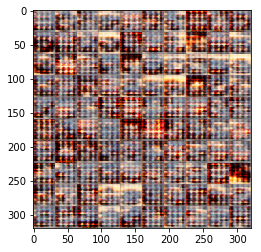

In [16]:
# 1 epoch
vis_image(read_image('result_class_1/preview/image00001000.png'))

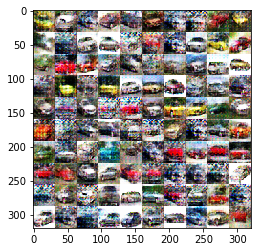

In [17]:
# 50 epoch, 3 hours
vis_image(read_image('result_class_1/preview/image00050000.png'))

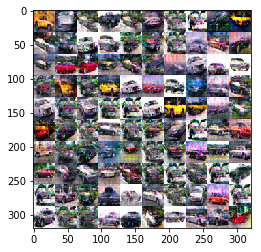

In [18]:
# 100 epoch, 6 hours
vis_image(read_image('result_class_1/preview/image00100000.png'))

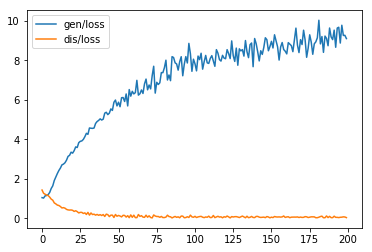

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

result = pd.read_json('result_class_1/log')
result[['gen/loss','dis/loss']].plot()

In [22]:
from PIL import Image
import glob
%matplotlib nbagg

files = sorted(glob.glob('result_class_1/preview/*.png'))
images = list(map(lambda file: Image.open(file), files))
images[0].save('result_class_1/preview/out.gif', save_all=True, append_images=images[1:], duration=100, loop=0)